In [10]:
library(tidyverse)
library(tidymodels)
library(themis)
library(repr)
library(broom)
library(infer)
library(cowplot)

options(repr.matrix.max.rows = 6)  
tidymodels_prefer()

Intro

## 1. Data Description

This project uses two datasets:

- **players.csv**  one row per player (demographics + gameplay summary)
- **sessions.csv** one row per play session (timestamps + durations)

Below is the structure, number of observations, and potential data issues.


In [11]:
players  <- read_csv("data/players.csv", show_col_types = FALSE)
sessions <- read_csv("data/sessions.csv", show_col_types = FALSE)

dim(players)
head(players)

dim(sessions)
head(sessions)

[1] 196   7

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


[1] 1535    5

hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


In [12]:
glimpse(players)

players |>
  summarise(
    n_players      = n(),
    mean_age       = mean(Age, na.rm = TRUE),
    min_age        = min(Age, na.rm = TRUE),
    max_age        = max(Age, na.rm = TRUE),
    mean_hours     = mean(played_hours, na.rm = TRUE),
    min_hours      = min(played_hours, na.rm = TRUE),
    max_hours      = max(played_hours, na.rm = TRUE)
  )

players |>
  count(experience) |>
  mutate(prop = n / sum(n))

players |>
  count(gender) |>
  mutate(prop = n / sum(n))

players |>
  count(subscribe)

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


n_players,mean_age,min_age,max_age,mean_hours,min_hours,max_hours
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
196,21.13918,9,58,5.845918,0,223.1


experience,n,prop
<chr>,<int>,<dbl>
Amateur,63,0.32142857
Beginner,35,0.17857143
Pro,14,0.07142857
Regular,36,0.18367347
Veteran,48,0.24489796


gender,n,prop
<chr>,<int>,<dbl>
Agender,2,0.01020408
Female,37,0.18877551
Male,124,0.63265306
⋮,⋮,⋮
Other,1,0.005102041
Prefer not to say,11,0.056122449
Two-Spirited,6,0.030612245


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,144


In [13]:
session_counts <- sessions |>
  group_by(hashedEmail) |>
  summarise(
    total_sessions = n(),
    .groups = "drop"
  )

players_full <- players |>
  left_join(session_counts, by = "hashedEmail") |>
  mutate(
    total_sessions = replace_na(total_sessions, 0L),
    subscribe      = factor(subscribe, levels = c(FALSE, TRUE), labels = c("no", "yes"))
  )

glimpse(players_full)
summary(players_full$total_sessions)

Rows: 196
Columns: 8
$ experience     <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Ama…
$ subscribe      <fct> yes, yes, no, yes, yes, yes, yes, no, yes, yes, yes, ye…
$ hashedEmail    <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728…
$ played_hours   <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6,…
$ name           <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adri…
$ gender         <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fe…
$ Age            <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, …
$ total_sessions <int> 27, 3, 1, 1, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 0, 0, 0, 37,…


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   0.000   1.000   7.832   1.000 310.000 

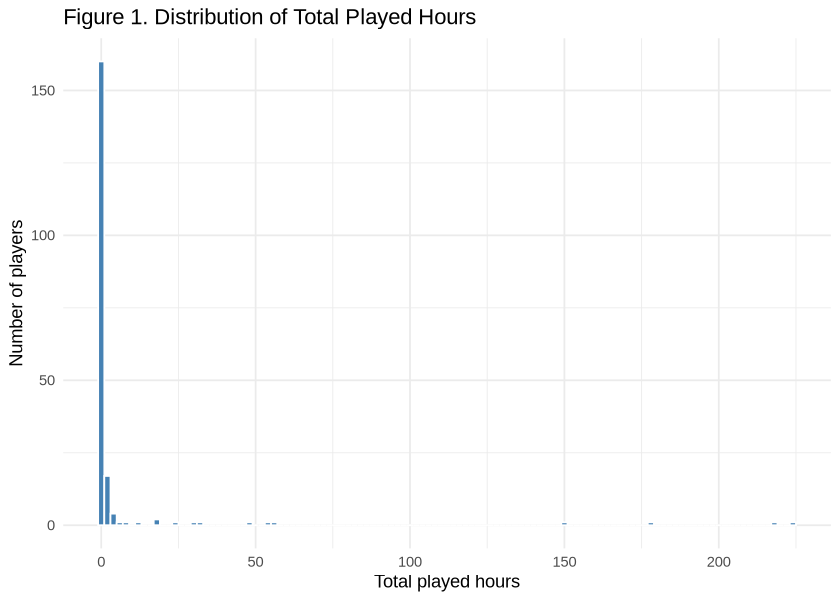

In [14]:
options(repr.plot.width = 7, repr.plot.height = 5)

ggplot(players_full, aes(x = played_hours)) +
  geom_histogram(binwidth = 2, fill = "steelblue", color = "white") +
  labs(
    title = "Figure 1. Distribution of Total Played Hours",
    x = "Total played hours",
    y = "Number of players"
  ) +
  theme_minimal()

## 2. Questions

### Broad Question
What player behaviours and patterns are most predictive of long term engagement on the server?

### Specific Question

Can the total number of sessions and total played hours predict whether a player subscribes to the newsletter?

### Why this question?

Newsletter subscription shows a  deeper engagement with the project, and understanding whether this behaviours (like number of sessions and total hours played) predict subscription helps the research team identify players what factors and who are most likely to stay subscribed


## 3. Exploratory Data Analysis and Visualization

Below are basic visualizations to understand key variables related to my predictive question.


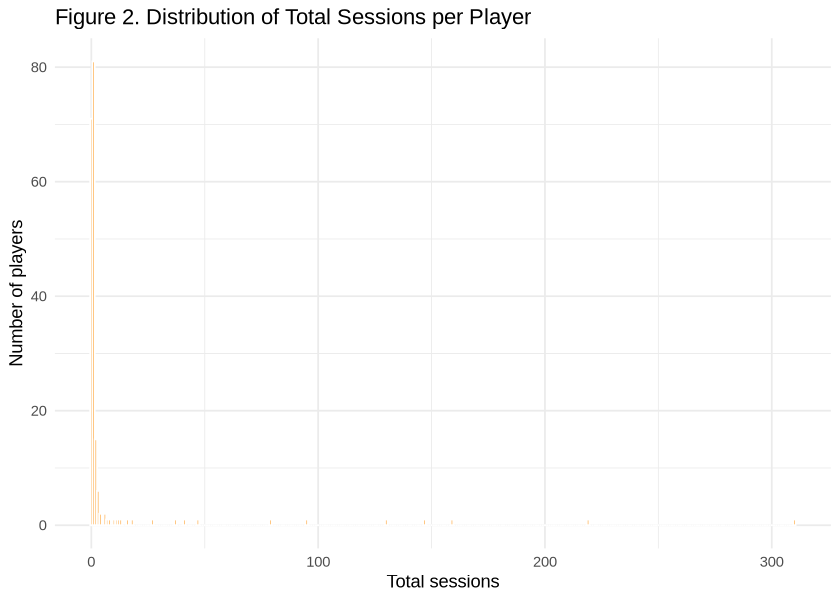

In [15]:
players_summary <- players %>%
  group_by(experience) %>%
  summarise(
    mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2),
    n_players = n()
  )

players_summary

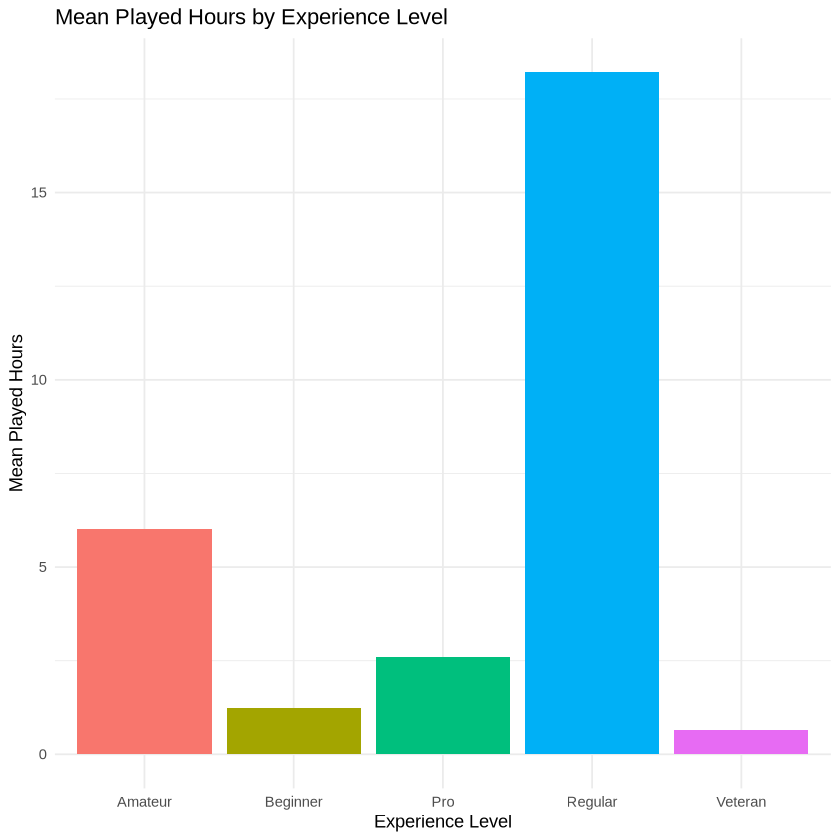

In [6]:
ggplot(players_summary, aes(x = experience, y = mean_played_hours, fill = experience)) +
  geom_col() +
  labs(title = "Mean Played Hours by Experience Level",
       x = "Experience Level",
       y = "Mean Played Hours") +
  theme_minimal() +
  theme(legend.position = "none")


### Comment:
More experienced players tend to have higher total played hours. This supports using both variables as predictors for newsletter subscription.


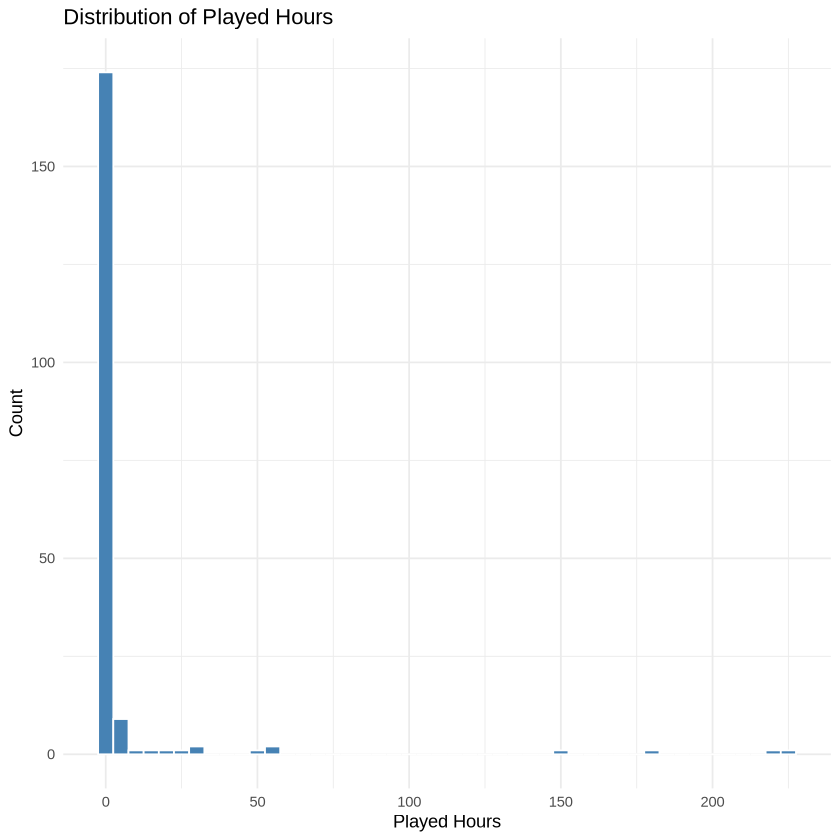

In [7]:
ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 5, fill = "steelblue", color = "white") +
  labs(title = "Distribution of Played Hours", x = "Played Hours", y = "Count") +
  theme_minimal()

### Comment:
The distribution of played_hours is bad as most players have low hours. This suggests we may need to scale, depending on the model.


## 4. Methods and Plan

### Proposed Method
**k-Nearest Neighbors Classification**

### Why this method?
- Only uses basic concepts such as distance and similarity
- Does not require assumptions about linear relationships
- Simple and easy to understand

### Assumptions
- Players who have similar experience/played hours will behave similarly
- Variables are on similar scales (we will normalize them)
- No missing values in the predictors

### Possible Limitations
- Must normalize numeric variables so one does not dominate the distance 
- Does not automatically show which variable is “most important”
- kNN can be slower with large datasets

### Data Processing Plan
1. Clean newsletter variable (convert to numeric 0/1).
2. Remove rows with missing values in key columns.
3. Normalize numeric predictors: played_hours, Age
4. Convert experience to a numeric scale
5. Train-test split:  
   - **80% training**, **20% test**  
6. Choose values of k to test 
7. Fit kNN model using training data.
8. Evaluate performance
9. Interpret results


## 5. GitHub Repository

My GitHub project repository:

**<https://github.com/daniel-zouli/Dsci-100-Individual-Project.git>**

In [8]:
" This project aims to explore the behaviours of players on a research Minecraft server to figure out which factors are most closely tied to newsletter subscription, a key signal of long term engagement and interest in the community. The dataset is made up of two files: players.csv, which has one row per player with details like age, gender, experience level, total hours played, hashed email, name, and subscription status; and sessions.csv, which records individual play sessions with login and logout times. The players.csv file contains 196 entries with a mix of numeric variables (age, played_hours, subscribe) and categorical ones (experience, gender, name, hashedEmail). The sessions.csv file is much larger since players can have multiple sessions, and its timestamp data will need extra cleaning before it can be used for time analysis. Key challenges in the data include missing values for age and played_hours, possible mismatches between played_hours and the total time calculated from sessions, and categorical variables stored as text instead of factors. Another important detail is that the subscription variable, coded as 0 or 1, should be treated as a numeric class label during modelling but converted to a factor for interpretation and evaluation. The broader research question guiding this work is: What player characteristics and behaviours are most related to continued engagement with the game? This matters because subscribing to the newsletter shows a player’s interest in staying connected with the project and its community. My specific focus is: Can a player’s experience level and total hours played predict whether they subscribe to the newsletter? This is a good fit because both variables are directly related to engagement experience which Shows skill, while played_hours shows actual time investment. Both are readily available in players.csv, so sessions.csv isn’t needed for this initial model. Exploratory analysis suggests that players with higher experience levels generally log more hours, and the distribution of played_hours is heavily skewed, with many players spending only a small amount of time on the server. These trends point to the idea that players who invest more time and report greater experience are more likely to subscribe. Visualizations like bar plots of average played_hours by experience category and histograms of played_hours highlight these differences, and early summaries show group level variation that could affect classification results. To answer my predictive question, I plan to use the k-Nearest Neighbours (kNN) classification method. Because the subscribe variable is binary, kNN is appropriate for treating subscription as a classification task. kNN is a simple, interpretable method consistent with the course content, relying only on distance calculations between players based on selected predictors. The assumptions include proper scaling of numeric variables, appropriate categorical variables such as experience, and the non variables that might distort distances. Potential limitations include unbalanced classes, the influence of variables on distance calculations, and the difficulty of interpreting the model beyond neighbour comparisons.For modelling, I will first clean and encode the necessary variables, scale the predictors, and then split the players.csv data into an 80% training set and a 20% test set. I will apply kNN to classify newsletter subscription based on experience and played_hours and evaluate performance using accuracy."

[1] " This project aims to explore the behaviours of players on a research Minecraft server to figure out which factors are most closely tied to newsletter subscription, a key signal of long term engagement and interest in the community. The dataset is made up of two files: players.csv, which has one row per player with details like age, gender, experience level, total hours played, hashed email, name, and subscription status; and sessions.csv, which records individual play sessions with login and logout times. The players.csv file contains 196 entries with a mix of numeric variables (age, played_hours, subscribe) and categorical ones (experience, gender, name, hashedEmail). The sessions.csv file is much larger since players can have multiple sessions, and its timestamp data will need extra cleaning before it can be used for time analysis. Key challenges in the data include missing values for age and played_hours, possible mismatches between played_hours and the total time calculated from sessions, and categorical variables stored as text instead of factors. Another important detail is that the subscription variable, coded as 0 or 1, should be treated as a numeric class label during modelling but converted to a factor for interpretation and evaluation. The broader research question guiding this work is: What player characteristics and behaviours are most related to continued engagement with the game? This matters because subscribing to the newsletter shows a player’s interest in staying connected with the project and its community. My specific focus is: Can a player’s experience level and total hours played predict whether they subscribe to the newsletter? This is a good fit because both variables are directly related to engagement experience which Shows skill, while played_hours shows actual time investment. Both are readily available in players.csv, so sessions.csv isn’t needed for this initial model. Exploratory analysis suggests that players with higher experience levels generally log more hours, and the distribution of played_hours is heavily skewed, with many players spending only a small amount of time on the server. These trends point to the idea that players who invest more time and report greater experience are more likely to subscribe. Visualizations like bar plots of average played_hours by experience category and histograms of played_hours highlight these differences, and early summaries show group level variation that could affect classification results. To answer my predictive question, I plan to use the k-Nearest Neighbours (kNN) classification method. Because the subscribe variable is binary, kNN is appropriate for treating subscription as a classification task. kNN is a simple, interpretable method consistent with the course content, relying only on distance calculations between players based on selected predictors. The assumptions include proper scaling of numeric variables, appropriate categorical variables such as experience, and the non variables that might distort distances. Potential limitations include unbalanced classes, the influence of variables on distance calculations, and the difficulty of interpreting the model beyond neighbour comparisons.For modelling, I will first clean and encode the necessary variables, scale the predictors, and then split the players.csv data into an 80% training set and a 20% test set. I will apply kNN to classify newsletter subscription based on experience and played_hours and evaluate performance using accuracy."